# SNN Conversion
We now want to convert our trained ANN network into an SNN network.

For this we can load our pretrained ANN and convert it using SINABS.

In [29]:
import torch
import torch.nn as nn
import sinabs
import sinabs.layers as sl
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt# Calculate MSE for all result dfs
from sklearn.metrics import mean_squared_error
# Calculate R2 for all result dfs
from sklearn.metrics import r2_score

In [30]:
# Model definition

ann = nn.Sequential(
    nn.Linear(3, 256),  # Input layer: 3 features (mu, sigma, x)
    nn.ReLU(),
    nn.Linear(256, 256),  # first hidden layer
    nn.ReLU(),
    nn.Linear(256, 256),  # second hidden layer
    nn.ReLU(),
    nn.Linear(256, 1)    # Output layer: single value for f(x; mu, sigma)
)

In [31]:
ann.load_state_dict(torch.load("./results/extraextra_lin_normalized_256_2HL_normalized_log1p/ann_epoch_250.pth"))

C:\Users\Lutz\AppData\Local\Temp\ipykernel_33608\2940520920.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann.load_state_dict(torch.load("./results/extraextra_lin_norm

<All keys matched successfully>

In [32]:
# Convert to SNN
num_time_steps_per_sample = 100

snn_lin_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample)

In [33]:
snn_lin_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1.), min_v_mem=Parameter containing:
    tensor(-1.), batch_size=-1, num_timesteps=100)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=T

We can see that the transformation replaced all ReLU() Activation functions with an IAFSqueeze Layer and added a spike_output layer of the same name.

We now need to test how the results compare with this transformed model.

In [34]:
# Get Test Dataset

# Load test dataset
test_df = pd.read_csv('./extraextra_lin_normalized_log1p_test_data.csv')

In [35]:
# Example of how to structure timestep dataset
from torchvision import datasets, transforms

class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, is_spiking=False, time_window=100):
        super().__init__(
            root=root, train=train, download=True, transform=transforms.ToTensor()
        )
        self.is_spiking = is_spiking
        self.time_window = time_window

    def __getitem__(self, index):
        img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
        # img is now a tensor of 1x28x28

        if self.is_spiking:
            img = (torch.rand(self.time_window, *img.shape) < img).float()

        return img, target
    
mnist = MNIST(root='./data', train=False, is_spiking=True, time_window=num_time_steps_per_sample)
img, target = mnist[0]
print(img.shape)
print(target.shape)
print(target)


torch.Size([100, 1, 28, 28])
torch.Size([])
tensor(7)


In [36]:
class DataFrameDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, is_spiking=False, timesteps=100):
        self.timesteps = timesteps
        self.is_spiking = is_spiking
        self.inputval = torch.Tensor(dataframe["Series1"])
        self.mean = torch.Tensor(dataframe["Series2"])
        self.std = torch.Tensor(dataframe["Series3"])
        self.features = torch.stack([self.inputval, self.mean, self.std], dim=1)
        self.labels = torch.Tensor(dataframe["Label"])

    def __len__(self):
        return len(self.inputval)

    def __getitem__(self, idx):
        feature = self.features[idx]        
        labels = self.labels[idx]
        
        # Repeat for timesteps
        if self.is_spiking:
            feature = feature.repeat(self.timesteps, 1)
            labels = labels.repeat(self.timesteps, 1)
        
        return feature, labels
    
test_dataset = DataFrameDataset(test_df, is_spiking=True, timesteps=num_time_steps_per_sample)

In [37]:
feature, label = test_dataset[0]
feature.shape

torch.Size([100, 3])

In [38]:
label.shape

torch.Size([100, 1])

In [39]:
BATCH_SIZE = 1024

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
snn_lin_out.eval()
# Try to run a batch
def eval_loop(dataloader, model, mode="mean", apply_from=0, is_norse=False):
    results = []

    for data, target in tqdm(dataloader):
        data, target = data.to("cpu"), target.to("cpu")
        # prepare data
        data = torch.swapaxes(input=data, axis0=0, axis1=1)
        target = torch.swapaxes(input=target, axis0=0, axis1=1)
        

        with torch.no_grad():
            output = model(data)
            if is_norse:
                print(f"Data shape: {data.shape}")
                output = output[0]
                print(output.shape)
            for i in range(BATCH_SIZE):
                try:
                    if not is_norse:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item()))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item()))
                        elif mode == "last":
                            results.append((target[0, i, :].item(), output[-1, i, :].item()))
                    else:
                        if mode == "mean":
                            results.append((target[0, i, :].item(), output[apply_from:, i, :].mean().item(), output))
                        elif mode == "count":
                            results.append((target[0, i, :].item(), (output[apply_from:, i, :] > 0).sum().item(), output))
                except Exception:
                    break
                
    return results

results = eval_loop(dataloader, snn_lin_out)
results_last = eval_loop(dataloader, snn_lin_out, mode="last")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

In [41]:
# Transform  results to dataframe
results_df = pd.DataFrame(results, columns=["target", "output"])
results_last_df = pd.DataFrame(results_last, columns=["target", "output"])

# Add absolute diff
results_df["abs_diff"] = abs(results_df["target"] - results_df["output"])
results_last_df["abs_diff"] = abs(results_last_df["target"] - results_last_df["output"])

results_df.head()

,target,output,abs_diff
0,0.325648,0.326856,0.001208
1,0.012644,0.320036,0.307392
2,0.124293,0.180248,0.055954
3,0.507193,1.150776,0.643583
4,0.008237,0.030247,0.022010


In [42]:
results_df.describe()

,target,output,abs_diff
count,2.000000e+05,200000.000000,2.000000e+05
mean,2.515965e-01,0.290053,1.892476e-01
std,5.147689e-01,0.278286,3.551134e-01
min,0.000000e+00,-0.683161,7.897615e-07
25%,3.799229e-09,0.099875,4.830275e-02
50%,4.375688e-02,0.243446,1.033605e-01
75%,3.334947e-01,0.379925,2.269966e-01
max,5.991320e+00,2.666121,6.561145e+00


In [46]:
results_last_df.describe()

,target,output,abs_diff
count,2.000000e+05,200000.000000,200000.000000
mean,2.515965e-01,0.275169,0.583656
std,5.147689e-01,0.955529,0.799629
min,0.000000e+00,-29.112446,0.000003
25%,3.799229e-09,-0.078483,0.175022
50%,4.375688e-02,0.285278,0.367503
75%,3.334947e-01,0.602856,0.708346
max,5.991320e+00,12.698441,35.095973


In [47]:
print(f"MSE: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"R2: {r2_score(results_df['target'], results_df['output'])}")
print(f"MSE: {mean_squared_error(results_last_df['target'], results_last_df['output'])}")
print(f"R2: {r2_score(results_last_df['target'], results_last_df['output'])}")


MSE: 0.1619195147559461
R2: 0.3889499802907582
MSE: 0.980057672708534
R2: -2.698530477486819


(array([6.6785e+04, 5.1444e+04, 2.3117e+04, 1.8019e+04, 1.4431e+04,
        9.5700e+03, 4.8940e+03, 2.3550e+03, 1.4520e+03, 1.0830e+03,
        8.8000e+02, 6.8400e+02, 5.8600e+02, 4.6900e+02, 3.9400e+02,
        3.3800e+02, 3.0900e+02, 2.7000e+02, 2.1100e+02, 1.8000e+02,
        1.7200e+02, 1.6300e+02, 1.3100e+02, 1.2000e+02, 1.1100e+02,
        9.2000e+01, 7.9000e+01, 8.4000e+01, 6.0000e+01, 6.4000e+01,
        5.7000e+01, 6.8000e+01, 6.7000e+01, 5.6000e+01, 4.9000e+01,
        4.9000e+01, 4.8000e+01, 3.5000e+01, 4.2000e+01, 3.2000e+01,
        3.3000e+01, 3.5000e+01, 4.0000e+01, 3.2000e+01, 3.9000e+01,
        2.8000e+01, 1.2000e+01, 1.6000e+01, 1.8000e+01, 2.1000e+01,
        2.4000e+01, 1.9000e+01, 1.4000e+01, 1.6000e+01, 1.1000e+01,
        1.9000e+01, 2.0000e+01, 1.2000e+01, 1.9000e+01, 1.8000e+01,
        1.0000e+01, 2.2000e+01, 2.0000e+01, 2.0000e+01, 2.5000e+01,
        1.6000e+01, 1.6000e+01, 1.7000e+01, 2.6000e+01, 2.7000e+01,
        2.0000e+01, 2.1000e+01, 1.6000e+01, 1.40

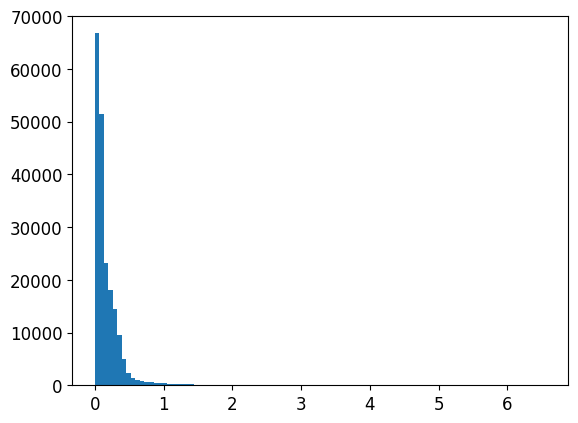

In [48]:
# Plot abs_diff
plt.hist(results_df["abs_diff"], bins=100)

             target         output       abs_diff
count  1.027480e+05  102748.000000  102748.000000
mean   3.260059e-01       0.380180       0.322826
std    6.791575e-01       0.316240       0.456077
min    0.000000e+00      -0.683161       0.100000
25%    7.528932e-11       0.189401       0.141881
50%    3.067505e-02       0.304692       0.222383
75%    3.661832e-01       0.448931       0.330637
max    5.991320e+00       2.666121       6.561145


(array([5.7545e+04, 7.3080e+03, 4.4470e+03, 3.2320e+03, 2.4310e+03,
        1.9340e+03, 1.6180e+03, 1.8280e+03, 1.6970e+03, 1.8070e+03,
        1.6560e+03, 1.6360e+03, 1.4830e+03, 1.2570e+03, 1.0420e+03,
        1.1000e+03, 8.6400e+02, 8.0100e+02, 7.0600e+02, 7.4900e+02,
        4.6800e+02, 5.6200e+02, 4.5800e+02, 3.1900e+02, 4.8500e+02,
        3.0100e+02, 3.2600e+02, 3.7800e+02, 2.2400e+02, 3.6700e+02,
        2.1100e+02, 1.2600e+02, 2.1300e+02, 2.5400e+02, 1.0900e+02,
        1.5300e+02, 1.8900e+02, 1.2200e+02, 8.5000e+01, 2.1300e+02,
        8.0000e+01, 3.1000e+01, 1.1300e+02, 2.0000e+02, 0.0000e+00,
        8.3000e+01, 4.3000e+01, 7.6000e+01, 9.3000e+01, 1.1300e+02,
        3.6000e+01, 0.0000e+00, 4.7000e+01, 3.8000e+01, 4.0000e+01,
        4.1000e+01, 0.0000e+00, 4.5000e+01, 8.0000e+01, 7.5000e+01,
        8.4000e+01, 0.0000e+00, 3.6000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.9000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.4000e+01, 0.0000e+00, 0.0000e+00, 0.00

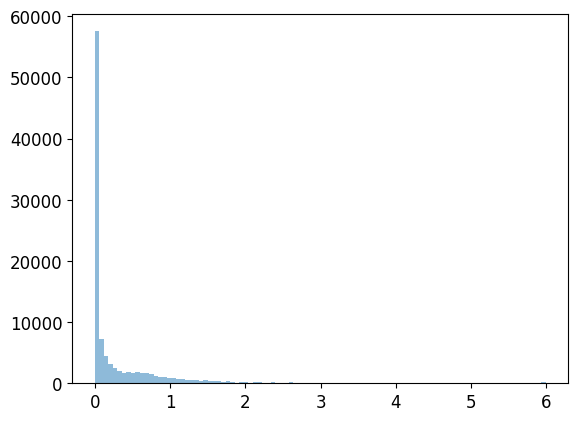

In [49]:
# Get the ones where abs_diff is greater than 0.1
print(results_df[results_df["abs_diff"] > 0.1].describe())

# Plot the targets and outputs for this subset
plt.hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=0.5, label="target")

             target        output      abs_diff
count  9.725200e+04  97252.000000  9.725200e+04
mean   1.729820e-01      0.194832  4.812053e-02
std    2.135417e-01      0.189615  2.843493e-02
min    0.000000e+00     -0.099976  7.897615e-07
25%    2.180944e-07      0.058803  2.366951e-02
50%    6.784844e-02      0.109893  4.690948e-02
75%    3.265245e-01      0.319392  7.227621e-02
max    2.172374e+00      2.214666  9.999999e-02


(array([4.1084e+04, 4.3620e+03, 2.8350e+03, 2.4280e+03, 2.1530e+03,
        1.9070e+03, 1.8920e+03, 1.8600e+03, 1.7720e+03, 1.9070e+03,
        1.9440e+03, 2.0280e+03, 1.9870e+03, 2.2460e+03, 2.4980e+03,
        3.2930e+03, 3.0520e+03, 2.6380e+03, 2.1320e+03, 1.9350e+03,
        1.6200e+03, 1.4350e+03, 1.1520e+03, 1.0550e+03, 7.8100e+02,
        7.3400e+02, 6.0700e+02, 4.9700e+02, 4.3800e+02, 3.5100e+02,
        3.6500e+02, 2.5900e+02, 2.1900e+02, 2.0500e+02, 1.4700e+02,
        1.4200e+02, 1.5800e+02, 9.2000e+01, 9.5000e+01, 8.4000e+01,
        9.4000e+01, 6.9000e+01, 5.1000e+01, 5.1000e+01, 4.4000e+01,
        5.3000e+01, 3.4000e+01, 4.8000e+01, 2.4000e+01, 1.8000e+01,
        3.9000e+01, 3.9000e+01, 2.7000e+01, 2.4000e+01, 1.3000e+01,
        2.6000e+01, 5.0000e+00, 1.7000e+01, 2.3000e+01, 8.0000e+00,
        9.0000e+00, 3.0000e+00, 1.1000e+01, 4.1000e+01, 0.0000e+00,
        6.0000e+00, 6.0000e+00, 8.0000e+00, 9.0000e+00, 8.0000e+00,
        0.0000e+00, 8.0000e+00, 0.0000e+00, 0.00

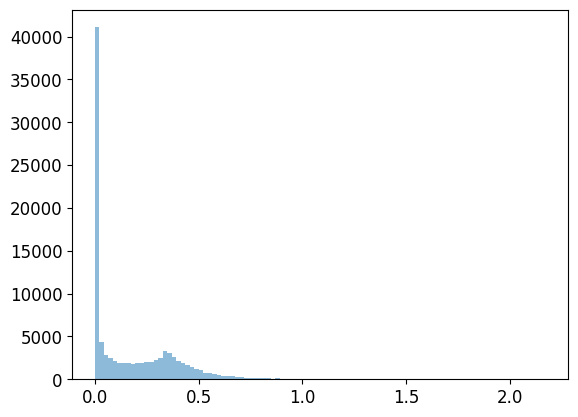

In [50]:
# Plot hist for the ones with error under 0.1
print(results_df[results_df["abs_diff"] < 0.1].describe())
plt.hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=0.5, label="target")

Text(0.5, 0.98, 'Distribution of target values for different error levels')

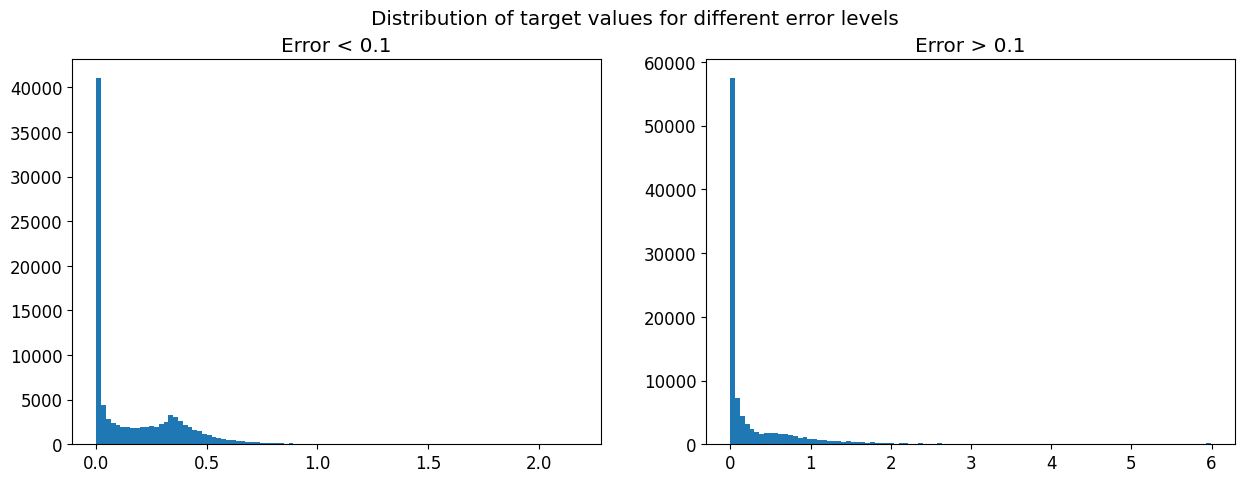

In [51]:
# Plot hist for the ones with error under 0.1 and ones with error higher than 0.1 next to each other in two subplots
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(results_df[results_df["abs_diff"] < 0.1]["target"], bins=100, alpha=1, label="target")
axs[1].hist(results_df[results_df["abs_diff"] > 0.1]["target"], bins=100, alpha=1, label="target")
axs[0].set_title("Error < 0.1")
axs[1].set_title("Error > 0.1")

# Figure title
fig.suptitle("Distribution of target values for different error levels")
# Font size



In [52]:
results2 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.1*num_time_steps_per_sample))
results3 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.2*num_time_steps_per_sample))
results4 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.3*num_time_steps_per_sample))
results5 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.4*num_time_steps_per_sample))
results6 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.5*num_time_steps_per_sample))

results_df2 = pd.DataFrame(results2, columns=["target", "output"])
results_df3 = pd.DataFrame(results3, columns=["target", "output"])
results_df4 = pd.DataFrame(results4, columns=["target", "output"])
results_df5 = pd.DataFrame(results5, columns=["target", "output"])
results_df6 = pd.DataFrame(results6, columns=["target", "output"])

results_df2["abs_diff"] = abs(results_df2["target"] - results_df2["output"])
results_df3["abs_diff"] = abs(results_df3["target"] - results_df3["output"])
results_df4["abs_diff"] = abs(results_df4["target"] - results_df4["output"])
results_df5["abs_diff"] = abs(results_df5["target"] - results_df5["output"])
results_df6["abs_diff"] = abs(results_df6["target"] - results_df6["output"])

print(f"Max error for 0.1: {results_df2['abs_diff'].max()}; mean error: {results_df2['abs_diff'].mean()}")
print(f"Max error for 0.2: {results_df3['abs_diff'].max()}; mean error: {results_df3['abs_diff'].mean()}")
print(f"Max error for 0.3: {results_df4['abs_diff'].max()}; mean error: {results_df4['abs_diff'].mean()}")
print(f"Max error for 0.4: {results_df5['abs_diff'].max()}; mean error: {results_df5['abs_diff'].mean()}")
print(f"Max error for 0.5: {results_df6['abs_diff'].max()}; mean error: {results_df6['abs_diff'].mean()}")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Max error for 0.1: 6.627692341804504; mean error: 0.17443200383922555
Max error for 0.2: 6.777256369590759; mean error: 0.16612888932234535
Max error for 0.3: 6.9218446016311646; mean error: 0.16239594345037603
Max error for 0.4: 6.9766175746917725; mean error: 0.16057482667530545
Max error for 0.5: 6.942449748516083; mean error: 0.15998082206850683


In [53]:


print(f"MSE for 0.0: {mean_squared_error(results_df['target'], results_df['output'])}")
print(f"MSE for 0.1: {mean_squared_error(results_df2['target'], results_df2['output'])}")
print(f"MSE for 0.2: {mean_squared_error(results_df3['target'], results_df3['output'])}")
print(f"MSE for 0.3: {mean_squared_error(results_df4['target'], results_df4['output'])}")
print(f"MSE for 0.4: {mean_squared_error(results_df5['target'], results_df5['output'])}")
print(f"MSE for 0.5: {mean_squared_error(results_df6['target'], results_df6['output'])}")


print(f"R2 for 0.0: {r2_score(results_df['target'], results_df['output'])}")
print(f"R2 for 0.1: {r2_score(results_df2['target'], results_df2['output'])}")
print(f"R2 for 0.2: {r2_score(results_df3['target'], results_df3['output'])}")
print(f"R2 for 0.3: {r2_score(results_df4['target'], results_df4['output'])}")
print(f"R2 for 0.4: {r2_score(results_df5['target'], results_df5['output'])}")
print(f"R2 for 0.5: {r2_score(results_df6['target'], results_df6['output'])}")

MSE for 0.0: 0.1619195147559461
MSE for 0.1: 0.1563279338340711
MSE for 0.2: 0.15982846335035134
MSE for 0.3: 0.16582099516356247
MSE for 0.4: 0.1677050130029915
MSE for 0.5: 0.16871641384264865
R2 for 0.0: 0.3889499802907582
R2 for 0.1: 0.4100514246575315
R2 for 0.2: 0.3968411662576109
R2 for 0.3: 0.37422661798595813
R2 for 0.4: 0.36711673293194924
R2 for 0.5: 0.3632999199681879


In [54]:
# Test for 0.8 and 0.9
results8 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.8*num_time_steps_per_sample))
results9 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.9*num_time_steps_per_sample))

results_df8 = pd.DataFrame(results8, columns=["target", "output"])
results_df9 = pd.DataFrame(results9, columns=["target", "output"])

results_df8["abs_diff"] = abs(results_df8["target"] - results_df8["output"])
results_df9["abs_diff"] = abs(results_df9["target"] - results_df9["output"])

print(f"Max error for 0.8: {results_df8['abs_diff'].max()}; mean error: {results_df8['abs_diff'].mean()}")
print(f"Max error for 0.9: {results_df9['abs_diff'].max()}; mean error: {results_df9['abs_diff'].mean()}")

print(f"MSE for 0.8: {mean_squared_error(results_df8['target'], results_df8['output'])}")
print(f"MSE for 0.9: {mean_squared_error(results_df9['target'], results_df9['output'])}")
print(f"R2 for 0.8: {r2_score(results_df8['target'], results_df8['output'])}")
print(f"R2 for 0.9: {r2_score(results_df9['target'], results_df9['output'])}")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Max error for 0.8: 7.349653482437134; mean error: 0.1759529357525611
Max error for 0.9: 8.220250844955444; mean error: 0.21225487080621536
MSE for 0.8: 0.18096002207212922
MSE for 0.9: 0.22442056681025646
R2 for 0.8: 0.3170951307479831
R2 for 0.9: 0.15308422224918639


In [55]:
# 06 and 07
results6 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.6*num_time_steps_per_sample))
results7 = eval_loop(dataloader, snn_lin_out, mode="mean", apply_from=int(0.7*num_time_steps_per_sample))

results_df6 = pd.DataFrame(results6, columns=["target", "output"])
results_df7 = pd.DataFrame(results7, columns=["target", "output"])

results_df6["abs_diff"] = abs(results_df6["target"] - results_df6["output"])
results_df7["abs_diff"] = abs(results_df7["target"] - results_df7["output"])

print(f"Max error for 0.6: {results_df6['abs_diff'].max()}; mean error: {results_df6['abs_diff'].mean()}")
print(f"Max error for 0.7: {results_df7['abs_diff'].max()}; mean error: {results_df7['abs_diff'].mean()}")

print(f"MSE for 0.6: {mean_squared_error(results_df6['target'], results_df6['output'])}")
print(f"MSE for 0.7: {mean_squared_error(results_df7['target'], results_df7['output'])}")
print(f"R2 for 0.6: {r2_score(results_df6['target'], results_df6['output'])}")
print(f"R2 for 0.7: {r2_score(results_df7['target'], results_df7['output'])}")

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

Max error for 0.6: 7.064499139785767; mean error: 0.16127472297848863
Max error for 0.7: 7.188853144645691; mean error: 0.16528735296986327
MSE for 0.6: 0.17058726230802568
MSE for 0.7: 0.17389180527613948
R2 for 0.6: 0.35623973334791115
R2 for 0.7: 0.34376908675018947


In [79]:
import pickle

with open(f"./extraextra_lin_normalized_log1p_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

In [89]:
import numpy as np
import plotly.express as px
import math

class SpiceSOM(nn.Module):
    """Run value(s) through a SPICEnet SOM with a single SNN acting as the SOM Neuron.
    The single SNN improves the efficiency of the SOM by running all neurons in parallel.

    Parameters:
        standard_deviation: list of standard deviations for all neurons in order of neurons.
        preferred_value: list of preferred values for all neurons in order of neurons.
        timesteps: The number of timesteps to run the SNN for.
    """
    def __init__(self,
                n_neurons: int,
                value_range_start: float,
                value_range_end: float,
                const_LR_interaction_kernel: float,
                const_LR_tuning_curve: float,
                timesteps: int):
        super().__init__()
        self.__iteration = 0
        self.const_LR_interaction_kernel = const_LR_interaction_kernel
        self.const_LR_tuning_curve = const_LR_tuning_curve
        
        distance = value_range_end - value_range_start
        step_size = distance / n_neurons
        
        self.preferred_value = []
        self.standard_deviation = []
        
        pos = value_range_start + step_size / 2.0

        for i in range(n_neurons):
            self.preferred_value.append(pos)
            self.standard_deviation.append(0.2)
            pos += step_size
            
        self.preferred_value = self.preferred_value
        self.standard_deviation = self.standard_deviation
        
        self.timesteps = timesteps
        
        self.som_snn = [snn_lin_out]

    @classmethod
    def from_lists(
        cls,
        standard_deviation: list[float],
        preferred_value: list[float],
        value_range_start: float,
        value_range_end: float,
        const_LR_interaction_kernel: float,
        const_LR_tuning_curve: float,
        timesteps: int,
    ):
        som = cls(len(standard_deviation), value_range_start, value_range_end, const_LR_interaction_kernel, const_LR_tuning_curve, timesteps)
        
        som.standard_deviation = standard_deviation
        som.preferred_value = preferred_value
        
        return som

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # Check input is the correct shape
        if input.dim() != 1:
            raise ValueError(f"Input must be 1D, got {input.dim()}D")
        
        result = []
        
        std_tensor = torch.Tensor(self.standard_deviation)
        pref_tensor = torch.Tensor(self.preferred_value)
        
        # Make std and prefered value the same shape as the input
        for value in input.tolist():
            # stack the input, std and prefered value
            repeated_value = torch.full_like(std_tensor, value)
            input = torch.stack((repeated_value, pref_tensor, std_tensor), dim=1)
            
            # Use scaler
            input = torch.Tensor(scaler.transform(input))
            
            # Repeat the input for the number of timesteps
            input = input.repeat(self.timesteps, 1, 1)
            
            with torch.no_grad():
                subresult = self.som_snn[0](input)
            result.append(subresult)
            
        # Transform result from list of answers for each neuron to list of activation vectors of each neuron for a value
        result = torch.stack(result, dim=0)
        
        # Descale
        return result[:, 50:, :, :].mean(dim=1)
    
    def __len__(self) -> int:
        return len(self.standard_deviation)
    
    def print_neurons(self):
        for i, (pref_val, std) in enumerate(zip(self.preferred_value, self.standard_deviation)):
            print(f"Neuron {i}: preferred value: {pref_val}, standard deviation: {std}")
            
    
    def fit(self, values: list[float], epochs: int):
        for epoch in range(epochs):
            for i in range(len(values)):
                winning_neuron_index, _ = self.__argmax_neuron_activation(values[i])

                for j in range(len(self.preferred_value)):
                    self.update_neuron(j, values[i],
                                             self.const_LR_tuning_curve, # Only constant LR
                                             self.const_LR_interaction_kernel, # Only constant LR
                                             j - winning_neuron_index)
                self.__iteration += 1
                
    def __argmax_neuron_activation(self, value: float):
        """
        Calculates the neuron with the highest activation value.
        :param value: The value for wich the activation values should be calculated.
        :return: The index of the winning neuron
        and a dictionary containing the index of a neuron with the calculated activation value.
        """
        # Get activation values over timesteps
        results = self.forward(torch.Tensor([value]))
        
        # Get the mean activation value over timesteps
        winner_neuron_values = results[0, :, 0]
        
        # Get the index of the winning neuron
        winner_neuron_index = torch.argmax(winner_neuron_values).item()
        activation_dict = {i: winner_neuron_values[i].item() for i in range(len(winner_neuron_values))}
        
        return winner_neuron_index, activation_dict
        
    def update_neuron(self, index: int, value: float, learn_rate: float, interaction_kernel_learning_rate: float,
                distance_to_winner: int):
        """
        Updates the weights of the neurons.
        :param index: index of the neuron to update
        :param value: The value in wich "direction" the neuron should move.
        :param learn_rate: The learn rate. (This value should be depending on the iteration.)
        :param interaction_kernel_learning_rate: The sigma of the interaction kernel.
        (This value should be depending on the iteration.)
        :param distance_to_winner: The distance between this neuron and the winning neuron, in the SOM.
        Here are not the weights / postions in the value range relevant.
        (N1 weight: 31.9) --- (N2 weight: 32) --- (N3 weight: 32.4) --- (N4 weight: 33)
        The Distance of N4 to N1 is 3
        :return:
        """
        interaction_kernel_value = math.exp(
            (-abs(distance_to_winner) ** 2) / (2 * interaction_kernel_learning_rate ** 2))
        self.preferred_value[index] += learn_rate * interaction_kernel_value * (value - self.preferred_value[index])
        self.standard_deviation[index] += learn_rate * interaction_kernel_value * (
                (value - self.preferred_value[index]) ** 2 - self.standard_deviation[index] ** 2
        )
        
    def all_activation_for_values(self, values: list[float]):
        """
        Returns the activation values for a list of values.
        :param values: The values for wich the activation has to be calculated.
        :return: An array of activation values, ordered like the input list.
        """
        return np.array([self.get_activation_vector(value) for value in values]).T

        
    def calculate_activation_values(self, values: list[float]):
        """
        Calculates activation values for all neurons in the som.
        :param values:
        :return: A numpy array the first col is the preferred value, second col is the tuning curve width
        and the following cols are the activation values.
        """
        activation_values = np.array(self.all_activation_for_values(values))
        return np.concatenate((
            np.array(
                [[pref for pref in self.preferred_value],
                 [std for std in self.standard_deviation]]).transpose(),
            activation_values),
            axis=1)

    def naive_decode(self, value: float, neuron_index: int) -> float:
        activation_value = value
        
        r = math.sqrt(2 * self.standard_deviation[neuron_index] ** 2 * math.log(
            math.sqrt(2 * math.pi) * activation_value * self.standard_deviation[neuron_index] ** 2, 10))

        if neuron_index < len(self.standard_deviation) / 2:
            return self.preferred_value[neuron_index] - r
        else:
            return self.preferred_value[neuron_index] + r
        
    def get_winning_neuron_index(self, value: float) -> tuple[int, float]:
        winning_neuron_index, activation_values = self.__argmax_neuron_activation(value)
        return winning_neuron_index, activation_values[winning_neuron_index]
    
    def get_activation_vector(self, value: float) -> np.array:
        # Get activation values over timesteps
        results = self.forward(torch.Tensor([value]))
        
        # Get the mean activation value over timesteps
        winner_neuron_values = results[0, :, 0]
        
        return np.array(winner_neuron_values.tolist())
    

    def get_as_matrix(self) -> np.ndarray:
        """
        Returns all neurons like a table with column 0 representing the preferred value
        and column 1 representing the tuning curve width.
        :return: A numpy matrix.
        """
        return np.array([self.preferred_value,
                         self.standard_deviation]).transpose()

def plot_som(som, select_all_button: bool = False):
    stem_x_values = som.get_as_matrix()[:, 0]
    x_min = stem_x_values.min()
    x_max = stem_x_values.max()
    distance = x_max - x_min
    x_min -= distance * 0.15
    x_max += distance * 0.15
    x_plt_vals = np.linspace(x_min, x_max, 500)
    activation_values = som.calculate_activation_values(x_plt_vals.tolist())
    df = pd.DataFrame(activation_values[:, 2:].transpose(), index=x_plt_vals)
    fig = px.line(df)
    if select_all_button:
        fig.update_layout(dict(updatemenus=[
            dict(
                type="buttons",
                direction="left",
                buttons=list([
                    dict(
                        args=["visible", "legendonly"],
                        label="Deselect All",
                        method="restyle"
                    ),
                    dict(
                        args=["visible", True],
                        label="Select All",
                        method="restyle"
                    )
                ]),
                pad={"r": 10, "t": 10},
                showactive=False,
                x=1,
                xanchor="right",
                y=1.1,
                yanchor="top"
            ),
        ]
        ))
    fig.show(title='Activation values')


In [90]:
som = SpiceSOM(100, -1, 1, 0.8, 0.8, 100)

In [91]:
plot_som(som)

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

c:\Users\Lutz\Bachelorarbeit2\SNN\.venv\Lib\s

In [88]:
# Save SNN model wit TorchScript to be able to load without class definition
#torch.save(snn_lin_out.spiking_model, "snn_lin_out.pt")

In [ ]:
# Export to NIR
# from sinabs import to_nir, from_nir
# from  sinabs.activation.reset_mechanism import MembraneSubtract

# nir_model = to_nir(snn_lin_out.spiking_model, test_dataset[0][0], "snn_lin_out")

# import norse.torch as norse

# norse_model = norse.from_nir(nir_model, reset_method=norse.reset_subtract)

# norse_model

GraphExecutor(
  (input): Identity()
  (0): Linear(in_features=3, out_features=256, bias=True)
  (1): IAFCell(
    p=IAFParameters(v_th=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 

In [ ]:
# for name, layer in norse_model.named_children():
#     if isinstance(layer, torch.nn.Linear):
#         print(name)
#         snn_lin_out_weights = snn_lin_out.spiking_model[int(name)].state_dict()['weight']
#         snn_lin_out_bias = snn_lin_out.spiking_model[int(name)].state_dict()['bias']
        
#         assert torch.allclose(layer.state_dict()['weight'], snn_lin_out_weights), f"Layer {name} weights are not equal"
#         assert torch.allclose(layer.state_dict()['bias'], snn_lin_out_bias), f"Layer {name} biases are not equal"

0
2
4
6


In [ ]:
# batch_1_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# results_norse = eval_loop(dataloader, norse_model, is_norse=True)

  0%|          | 0/196 [00:00<?, ?it/s]

Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape: torch.Size([100, 1024, 3])
torch.Size([100, 1024, 1])
Data shape

In [ ]:
# results_df_norse = pd.DataFrame(results_norse, columns=["target", "output", "model_output"])
# results_df_norse["abs_diff"] = abs(results_df_norse["target"] - results_df_norse["output"])
# results_df_norse.head()

,target,output,model_output,abs_diff
0,0.036083,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.009308
1,0.061312,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.015921
2,0.023691,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.021700
3,0.622410,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.577019
4,0.116947,0.045391,"[[[tensor(0.0454)], [tensor(0.0454)], [tensor(...",0.071556


In [ ]:
# # Metrics
# print(f"Max error for norse: {results_df_norse['abs_diff'].max()}; mean error: {results_df_norse['abs_diff'].mean()}")
# print(f"MSE for norse: {mean_squared_error(results_df_norse['target'], results_df_norse['output'])}")
# print(f"R2 for norse: {r2_score(results_df_norse['target'], results_df_norse['output'])}")

Max error for norse: 3.9440310560166836; mean error: 0.10447808228115227
MSE for norse: 0.09407019632694077
R2 for norse: -0.044375330335329366


# First results
We can see that on average our results are pretty okay with the the mean absolute difference being around 0.01, with some having larger error, specifically those that would have a higher target number anyways reaching an error of up to 0.7.

We can also see that if we give the SNN some time to reach around the target and only take the average of, for example, the second half of the timesteps our results improve again by a good amount.

Most records with small targets also have small error, showing some sort of correlation here.

We want to now see how the outputs look if we were to count spike outputs for each input

In [29]:
from sinabs.activation import MembraneReset, SingleSpike, MultiSpike, MembraneSubtract

snn_spike_out = sinabs.from_model(ann, input_shape=(3,), add_spiking_output=False, synops=False, num_timesteps=num_time_steps_per_sample, spike_threshold=torch.tensor(1),
                                  min_v_mem=-1,
                                  spike_fn=SingleSpike)
snn_spike_out

Network(
  (spiking_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): IAFSqueeze(spike_threshold=Parameter containing:
    tensor(1), min_v_mem=Parameter containing:
    tensor(-1), batch_size=-1, num_timesteps=100)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (analog_model): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
 

In [30]:
results = eval_loop(dataloader, snn_spike_out, mode="count")
results_df_count = pd.DataFrame(results, columns=["target", "count"])

  0%|          | 0/196 [00:00<?, ?it/s]

In [31]:
results_df_count["target/count"] = results_df_count["target"] / results_df_count["count"]

In [32]:
results_df_count.head()

,target,count,target/count
0,0.036083,87,0.000415
1,0.061312,90,0.000681
2,0.023691,87,0.000272
3,0.622410,95,0.006552
4,0.116947,75,0.001559


In [33]:
results_df_count.describe()

,target,count,target/count
count,2.000000e+05,200000.000000,2.000000e+05
mean,1.086131e-01,83.185865,1.311068e-03
std,3.001227e-01,5.622324,3.672853e-03
min,0.000000e+00,42.000000,0.000000e+00
25%,2.247868e-08,80.000000,2.767927e-10
50%,3.664592e-02,84.000000,4.331738e-04
75%,9.494516e-02,87.000000,1.134101e-03
max,3.989422e+00,100.000000,6.770100e-02


In [34]:
results_df_count[results_df_count["count"] == 50].describe()

,target,count,target/count
count,3.700000e+01,37.0,3.700000e+01
mean,2.743700e-03,50.0,5.487400e-05
std,7.334097e-03,0.0,1.466819e-04
min,0.000000e+00,50.0,0.000000e+00
25%,0.000000e+00,50.0,0.000000e+00
50%,3.987227e-13,50.0,7.974454e-15
75%,3.987228e-05,50.0,7.974457e-07
max,2.914367e-02,50.0,5.828734e-04


(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 5.0000e+00, 0.0000e+00,
        9.0000e+00, 1.1000e+01, 0.0000e+00, 1.1000e+01, 0.0000e+00,
        1.2000e+01, 0.0000e+00, 2.1000e+01, 3.7000e+01, 0.0000e+00,
        3.1000e+01, 0.0000e+00, 5.3000e+01, 7.5000e+01, 0.0000e+00,
        8.3000e+01, 0.0000e+00, 1.2200e+02, 0.0000e+00, 1.4100e+02,
        1.6100e+02, 0.0000e+00, 1.8100e+02, 0.0000e+00, 2.0100e+02,
        0.0000e+00, 2.1400e+02, 2.1000e+02, 0.0000e+00, 2.2800e+02,
        0.0000e+00, 2.6000e+02, 2.7200e+02, 0.0000e+00, 2.5700e+02,
        0.0000e+00, 3.1900e+02, 0.0000e+00, 3.0000e+02, 3.7200e+02,
        0.0000e+00, 4.7800e+02, 0.0000e+00, 6.3800e+02, 0.0000e+00,
        8.1400e+02, 1.2170e+03, 0.0000e+00, 1.7130e+03, 0.0000e+00,
        2.2640e+03, 3.2680e+03, 0.0000e+00, 4.6280e+03, 0.0000e+00,
        6.0400e+03, 0.0000e+00, 7.8290e+03, 9.6060e+03, 0.0000e+00,
        1.1470e+04, 0.0000e+00, 1.2970e+04, 1.4761e+04, 0.0000e+00,
        1.5635e+04, 0.0000e+00, 1.6498e+04, 0.00

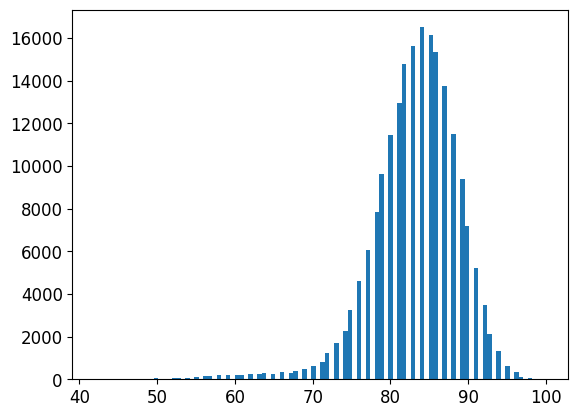

In [35]:
plt.hist(results_df_count["count"], bins=100)

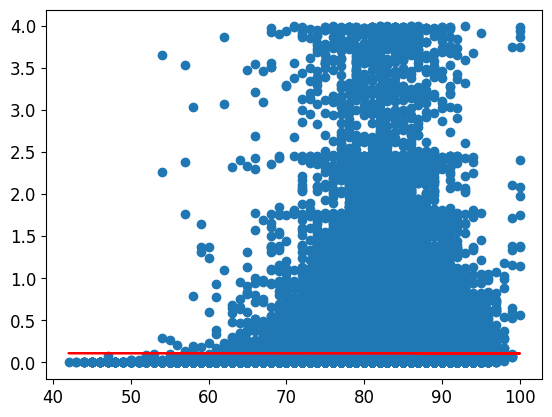

In [36]:
# Plot x as count and y as target

plt.scatter(results_df_count["count"], results_df_count["target"])

# Add regression line
import numpy as np
from sklearn.linear_model import LinearRegression

X = results_df_count["count"].values.reshape(-1, 1)
y = results_df_count["target"].values

reg = LinearRegression().fit(X, y)

plt.plot(X, reg.predict(X), color='red')
